# SVM

In [101]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer

## Metrics

In [102]:
def rocauc(true, score):
    # sort indices by probability
    sorted_indices = np.argsort(score)

    # sort the actuals by probability (l to g)
    true_sort = true[sorted_indices]

    # sort the probability (l to g)
    score_sort = score[sorted_indices]

    # vector of true positives (cumulative sum)
    TP = np.cumsum(true_sort)

    # vector of false positives (cumulative sum)
    FP = np.cumsum(1 - true_sort)

    # get true positive rate vector
    TPR = TP / TP[-1]

    # get false positive rate vector
    FPR = FP / FP[-1]

    # area under curve (TPR vs. FPR)
    rocauc_score = np.trapz(FPR, TPR)

    return rocauc_score

def metrics(true, pred):
    # get TP, TN, FP, FN
    TP = np.sum((pred == 1) & (true == 1))
    TN = np.sum((pred == 0) & (true == 0))
    FP = np.sum((pred == 1) & (true == 0))
    FN = np.sum((pred == 0) & (true == 1))

    # accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    # precision
    if TP + FP > 0:
        precision = TP / (TP + FP)
    else:
        precision = 0

    # recall
    if TP + FN > 0:
        recall = TP / (TP + FN)
    else:
        recall = 0

    # f1 score
    f1 = 0
    if precision + recall > 0:
        f1 = 2 * precision * recall / (precision + recall)
    else:
        recall = 0

    return accuracy, precision, recall, f1

def matthews_correlation_coefficient(y_true, y_pred):
    tp = sum((y_true == 1) & (y_pred == 1))
    tn = sum((y_true == 0) & (y_pred == 0))
    fp = sum((y_true == 0) & (y_pred == 1))
    fn = sum((y_true == 1) & (y_pred == 0))
    
    numerator = (tp * tn) - (fp * fn)
    denominator = ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5
    
    if denominator == 0:
        return 0
    return numerator / denominator

## Splits

In [103]:
def random_split(X, y, train_ratio=0.6, val_ratio=0.2):
    n_total = X.shape[0]
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)

    indices = np.random.permutation(n_total)

    train_indices = indices[:n_train]
    val_indices = indices[n_train:n_train + n_val]
    test_indices = indices[n_train + n_val:]

    X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
    X_val, y_val = X.iloc[val_indices], y.iloc[val_indices]
    X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]

    return X_train, y_train, X_val, y_val, X_test, y_test

def stratified_split(X, y, train_ratio=0.6, val_ratio=0.2):
    unique_classes, class_counts = np.unique(y, return_counts=True)
    train_indices, val_indices, test_indices = [], [], []

    for cls, count in zip(unique_classes, class_counts):
        cls_indices = np.where(y == cls)[0]
        np.random.shuffle(cls_indices)
        n_train_cls = int(count * train_ratio)
        n_val_cls = int(count * val_ratio)

        train_indices.extend(cls_indices[:n_train_cls])
        val_indices.extend(cls_indices[n_train_cls:n_train_cls + n_val_cls])
        test_indices.extend(cls_indices[n_train_cls + n_val_cls:])

    train_indices = np.array(train_indices)
    val_indices = np.array(val_indices)
    test_indices = np.array(test_indices)

    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)
    np.random.shuffle(test_indices)

    X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
    X_val, y_val = X.iloc[val_indices], y.iloc[val_indices]
    X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]

    return X_train, y_train, X_val, y_val, X_test, y_test

def sorted_split(X, y, sort_column, train_ratio=0.6, val_ratio=0.2):
    sorted_indices = X[sort_column].argsort()
    X_sorted = X.iloc[sorted_indices]
    y_sorted = y.iloc[sorted_indices]

    n_total = X.shape[0]
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)
    n_test = n_total - n_train - n_val

    train_indices, val_indices, test_indices = [], [], []
    block_size = 10

    for i in range(0, n_total, block_size):
        block_indices = range(i, min(i + block_size, n_total))
        if len(train_indices) < n_train:
            train_indices.extend(block_indices)
        elif len(val_indices) < n_val:
            val_indices.extend(block_indices)
        else:
            test_indices.extend(block_indices)

    X_train, y_train = X_sorted.iloc[train_indices], y_sorted.iloc[train_indices]
    X_val, y_val = X_sorted.iloc[val_indices], y_sorted.iloc[val_indices]
    X_test, y_test = X_sorted.iloc[test_indices], y_sorted.iloc[test_indices]

    return X_train, y_train, X_val, y_val, X_test, y_test

## Data

Merged Dataset:

In [104]:
df_merged = pd.read_csv('./merge_cleaned.csv')

# take a subset of the rows so that runtime is faster
df_merged = df_merged.sample(n=50000, random_state=42)

# drop rows with missing values in the following columns
cols = ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
df_merged = df_merged.dropna(subset=cols)

df_merged = df_merged.set_index('SK_ID_CURR')
df_merged = df_merged.drop(columns=['Unnamed: 0'])

# value counts of missing values
missing_values = df_merged.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values = missing_values.sort_values(ascending=False)
print(missing_values)

df_merged.head()

Series([], dtype: int64)


TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                                     
384575           0          1.0             1                0             2   
214010           0          0.0             1                1             0   
142232           0          0.0             1                0             0   
283617           0          1.0             0                1             0   
134561           1          0.0             0                0             4   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
384575              207000.0    465457.5      52641.0         418500.0   
214010              247500.0   1281712.5      48946.5        1179000.0   
142232              202500.0    495000.0      39109.5         495000.0   
283617              112500.0    308133.0      15862.5         234000.0   
134561               67500.0    331920.0      17077.5         225000.0   

            REGION_POPULATION_RELATIVE  ...  NAME_FAMILY_STATUS_Separated  \
SK_ID_CURR                              ...                                 
384575                        0.009630  ...                             0   
214010                        0.006852  ...                             0   
142232                        0.035792  ...                             0   
283617                        0.018850  ...                             0   
134561                        0.006305  ...                             0   

            NAME_FAMILY_STATUS_Single / not married  \
SK_ID_CURR                                            
384575                                            0   
214010                                            1   
142232                                            0   
283617                                            1   
134561                                            0   

            NAME_FAMILY_STATUS_Unknown  NAME_FAMILY_STATUS_Widow  \
SK_ID_CURR                                                         
384575                               0                         0   
214010                               0                         0   
142232                               0                         0   
283617                               0                         0   
134561                               0                         0   

            NAME_HOUSING_TYPE_Co-op apartment  \
SK_ID_CURR                                      
384575                                      0   
214010                                      0   
142232                                      0   
283617                                      0   
134561                                      0   

            NAME_HOUSING_TYPE_House / apartment  \
SK_ID_CURR                                        
384575                                        1   
214010                                        1   
142232                                        1   
283617                                        1   
134561                                        1   

            NAME_HOUSING_TYPE_Municipal apartment  \
SK_ID_CURR                                          
384575                                          0   
214010                                          0   
142232                                          0   
283617                                          0   
134561                                          0   

            NAME_HOUSING_TYPE_Office apartment  \
SK_ID_CURR                                       
384575                                       0   
214010                                       0   
142232                                       0   
283617                                       0   
134561                                       0   

            NAME_HOUSING_TYPE_Rented apartment  NAME_HOUSING_TYPE_With parents  
SK_ID_CURR             

Application Dataset:

In [105]:
df_application = pd.read_csv('./application_cleaned.csv')
df_application = df_application.set_index('SK_ID_CURR')
df_application = df_application.drop(columns=['Unnamed: 0'])

# take a subset of the rows so that runtime is faster
df_application = df_application.sample(n=50000, random_state=42)

# drop rows with missing values in the following columns
cols = ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'CODE_GENDER', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
df_application = df_application.dropna(subset=cols)

# value counts of missing values
missing_values = df_application.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values = missing_values.sort_values(ascending=False)
print(missing_values)

df_application.head()

Series([], dtype: int64)


TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                                     
384575           0          1.0             1                0             2   
214010           0          0.0             1                1             0   
142232           0          0.0             1                0             0   
283617           0          1.0             0                1             0   
134561           1          0.0             0                0             4   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
384575              207000.0    465457.5      52641.0         418500.0   
214010              247500.0   1281712.5      48946.5        1179000.0   
142232              202500.0    495000.0      39109.5         495000.0   
283617              112500.0    308133.0      15862.5         234000.0   
134561               67500.0    331920.0      17077.5         225000.0   

            REGION_POPULATION_RELATIVE  ...  NAME_FAMILY_STATUS_Separated  \
SK_ID_CURR                              ...                                 
384575                        0.009630  ...                             0   
214010                        0.006852  ...                             0   
142232                        0.035792  ...                             0   
283617                        0.018850  ...                             0   
134561                        0.006305  ...                             0   

            NAME_FAMILY_STATUS_Single / not married  \
SK_ID_CURR                                            
384575                                            0   
214010                                            1   
142232                                            0   
283617                                            1   
134561                                            0   

            NAME_FAMILY_STATUS_Unknown  NAME_FAMILY_STATUS_Widow  \
SK_ID_CURR                                                         
384575                               0                         0   
214010                               0                         0   
142232                               0                         0   
283617                               0                         0   
134561                               0                         0   

            NAME_HOUSING_TYPE_Co-op apartment  \
SK_ID_CURR                                      
384575                                      0   
214010                                      0   
142232                                      0   
283617                                      0   
134561                                      0   

            NAME_HOUSING_TYPE_House / apartment  \
SK_ID_CURR                                        
384575                                        1   
214010                                        1   
142232                                        1   
283617                                        1   
134561                                        1   

            NAME_HOUSING_TYPE_Municipal apartment  \
SK_ID_CURR                                          
384575                                          0   
214010                                          0   
142232                                          0   
283617                                          0   
134561                                          0   

            NAME_HOUSING_TYPE_Office apartment  \
SK_ID_CURR                                       
384575                                       0   
214010                                       0   
142232                                       0   
283617                                       0   
134561                                       0   

            NAME_HOUSING_TYPE_Rented apartment  NAME_HOUSING_TYPE_With parents  
SK_ID_CURR             

## Random Split SVM on Application Data and Merged Data

Merged Data:

In [106]:
# standardize the columns
from sklearn.preprocessing import StandardScaler
X = df_merged.drop(columns=['TARGET'])
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
y = df_merged['TARGET']

X_train, y_train, X_val, y_val, X_test, y_test = random_split(X, y)
y_test = y_test.to_numpy()

columns_to_scale = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), columns_to_scale)
    ], remainder='passthrough'
)

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

model = SVC(gamma='auto', class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.decision_function(X_test)

accuracy, precision, recall, f1 = metrics(y_test, y_pred)
mcc = matthews_correlation_coefficient(y_test, y_pred)
rocauc_score = rocauc(y_test, y_prob)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'MCC: {mcc}')
print(f'ROC AUC: {rocauc_score}')

# sklearn metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
mcc = matthews_corrcoef(y_test, y_pred)

print()
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'MCC: {mcc}')
print(f'ROC AUC: {roc_auc}')

Accuracy: 0.7519138077686419
Precision: 0.14672686230248308
Recall: 0.5220883534136547
F1 Score: 0.2290748898678414
MCC: 0.17214005212190855
ROC AUC: 0.7205600927198728

Accuracy: 0.7519138077686419
Precision: 0.14672686230248308
Recall: 0.5220883534136547
F1 Score: 0.2290748898678414
MCC: 0.17214005212190855
ROC AUC: 0.7205600927198725


Application Data:

In [107]:
X = df_application.drop(columns=['TARGET'])
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
y = df_application['TARGET']

X_train, y_train, X_val, y_val, X_test, y_test = random_split(X, y)
y_test = y_test.to_numpy()

columns_to_scale = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), columns_to_scale)
    ], remainder='passthrough'
)

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

model = SVC(gamma='auto', class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.decision_function(X_test)

accuracy, precision, recall, f1 = metrics(y_test, y_pred)
mcc = matthews_correlation_coefficient(y_test, y_pred)
rocauc_score = rocauc(y_test, y_prob)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'MCC: {mcc}')
print(f'ROC AUC: {rocauc_score}')

# sklearn metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
mcc = matthews_corrcoef(y_test, y_pred)

print()
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'MCC: {mcc}')
print(f'ROC AUC: {roc_auc}')

Accuracy: 0.7074000567054154
Precision: 0.13922859830667922
Recall: 0.5584905660377358
F1 Score: 0.22289156626506024
MCC: 0.159699544993092
ROC AUC: 0.6918778848489756

Accuracy: 0.7074000567054154
Precision: 0.13922859830667922
Recall: 0.5584905660377358
F1 Score: 0.22289156626506024
MCC: 0.159699544993092
ROC AUC: 0.6918778848489757


## Stratified Split SVM on Application Data and Merged Data

Merged Data:

In [108]:
X = df_merged.drop(columns=['TARGET'])
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
y = df_merged['TARGET']

X_train, y_train, X_val, y_val, X_test, y_test = stratified_split(X, y)
y_test = y_test.to_numpy()

columns_to_scale = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), columns_to_scale)
    ], remainder='passthrough'
)

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

model = SVC(gamma='auto', class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.decision_function(X_test)

accuracy, precision, recall, f1 = metrics(y_test, y_pred)
mcc = matthews_correlation_coefficient(y_test, y_pred)
rocauc_score = rocauc(y_test, y_prob)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'MCC: {mcc}')
print(f'ROC AUC: {rocauc_score}')

# sklearn metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
mcc = matthews_corrcoef(y_test, y_pred)

print()
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'MCC: {mcc}')
print(f'ROC AUC: {roc_auc}')

Accuracy: 0.7457482993197279
Precision: 0.14079822616407983
Recall: 0.5100401606425703
F1 Score: 0.22067767158992185
MCC: 0.16068483674763817
ROC AUC: 0.701270467658986

Accuracy: 0.7457482993197279
Precision: 0.14079822616407983
Recall: 0.5100401606425703
F1 Score: 0.22067767158992185
MCC: 0.16068483674763817
ROC AUC: 0.701270467658986


Application Data:

In [109]:
X = df_application.drop(columns=['TARGET'])
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
y = df_application['TARGET']

X_train, y_train, X_val, y_val, X_test, y_test = stratified_split(X, y)
y_test = y_test.to_numpy()

columns_to_scale = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), columns_to_scale)
    ], remainder='passthrough'
)

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

model = SVC(gamma='auto', class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.decision_function(X_test)

accuracy, precision, recall, f1 = metrics(y_test, y_pred)
mcc = matthews_correlation_coefficient(y_test, y_pred)
rocauc_score = rocauc(y_test, y_prob)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'MCC: {mcc}')
print(f'ROC AUC: {rocauc_score}')

# sklearn metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
mcc = matthews_corrcoef(y_test, y_pred)

print()
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'MCC: {mcc}')
print(f'ROC AUC: {roc_auc}')

Accuracy: 0.7321428571428571
Precision: 0.15269461077844312
Recall: 0.6144578313253012
F1 Score: 0.2446043165467626
MCC: 0.20193201329974855
ROC AUC: 0.7360212426405837

Accuracy: 0.7321428571428571
Precision: 0.15269461077844312
Recall: 0.6144578313253012
F1 Score: 0.2446043165467626
MCC: 0.20193201329974855
ROC AUC: 0.7360212426405838


## Custom Split SVM on Application Data and Merged Data

Merged Data:

In [110]:
X = df_merged.drop(columns=['TARGET'])
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
y = df_merged['TARGET']

X_train, y_train, X_val, y_val, X_test, y_test = sorted_split(X, y, 'AMT_INCOME_TOTAL')
y_test = y_test.to_numpy()

columns_to_scale = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), columns_to_scale)
    ], remainder='passthrough'
)

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

model = SVC(gamma='auto', class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.decision_function(X_test)

accuracy, precision, recall, f1 = metrics(y_test, y_pred)
mcc = matthews_correlation_coefficient(y_test, y_pred)
rocauc_score = rocauc(y_test, y_prob)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'MCC: {mcc}')
print(f'ROC AUC: {rocauc_score}')

# sklearn metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
mcc = matthews_corrcoef(y_test, y_pred)

print()
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'MCC: {mcc}')
print(f'ROC AUC: {roc_auc}')

Accuracy: 0.8386821925589322
Precision: 0.15139442231075698
Recall: 0.3486238532110092
F1 Score: 0.21111111111111114
MCC: 0.15140168464232978
ROC AUC: 0.7099064792362796

Accuracy: 0.8386821925589322
Precision: 0.15139442231075698
Recall: 0.3486238532110092
F1 Score: 0.21111111111111114
MCC: 0.15140168464232978
ROC AUC: 0.7099099511981046


Application Data:

In [117]:
X = df_application.drop(columns=['TARGET'])
# scaler = StandardScaler()
# X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
y = df_application['TARGET']

X_train, y_train, X_val, y_val, X_test, y_test = sorted_split(X, y, 'AMT_INCOME_TOTAL')
y_test = y_test.to_numpy()

columns_to_scale = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), columns_to_scale)
    ], remainder='passthrough'
)

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

model = SVC(gamma='auto', class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.decision_function(X_test)

accuracy, precision, recall, f1 = metrics(y_test, y_pred)
mcc = matthews_correlation_coefficient(y_test, y_pred)
rocauc_score = rocauc(y_test, y_prob)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'MCC: {mcc}')
print(f'ROC AUC: {rocauc_score}')

# sklearn metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
mcc = matthews_corrcoef(y_test, y_pred)

print()
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'MCC: {mcc}')
print(f'ROC AUC: {roc_auc}')

# figure out which features from the svm model are most important
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

for i in sorted_idx:
    print(f'{X.columns[i]}: {result.importances_mean[i]} +/- {result.importances_std[i]}')

Accuracy: 0.7344504402158478
Precision: 0.11657754010695187
Recall: 0.5
F1 Score: 0.18907198612315698
MCC: 0.13638637040930693
ROC AUC: 0.667979068236549

Accuracy: 0.7344504402158478
Precision: 0.11657754010695187
Recall: 0.5
F1 Score: 0.18907198612315698
MCC: 0.13638637040930693
ROC AUC: 0.667986012160199
AMT_INCOME_TOTAL: -0.024027264981539297 +/- 0.003707829348564058
CODE_GENDER: -0.00400454416358983 +/- 0.0025097570701636206
AGE: -0.0036353308719113352 +/- 0.004673327616490014
NAME_FAMILY_STATUS_Single / not married: -0.0030673104231751626 +/- 0.000982199174427197
REGION_POPULATION_RELATIVE: -0.0028969042885543137 +/- 0.0010458365600410227
NAME_TYPE_SUITE_Unaccompanied: -0.002499289974439001 +/- 0.0006696862324653079
NAME_INCOME_TYPE_Working: -0.0017892644135188319 +/- 0.0015661818436764603
NAME_TYPE_SUITE_Family: -0.0014200511218402934 +/- 0.0005080529343935968
NAME_HOUSING_TYPE_House / apartment: -0.0010508378301618214 +/- 0.001171348516177264
NAME_HOUSING_TYPE_With parents: -0.

In [ ]:
# visualize the roc-auc curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

NameError: name 'y_test' is not defined

0    16392
1     1239
Name: TARGET, dtype: int64


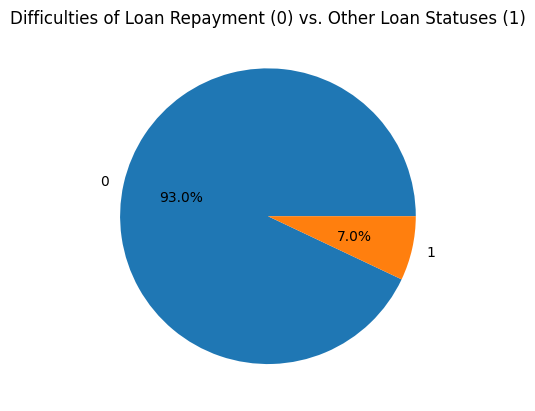

In [ ]:
# make a visualization showing the class imbalance (pie chart)

# value counts of target variable
target_counts = df_merged['TARGET'].value_counts()
print(target_counts)

plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%')
plt.title('Difficulties of Loan Repayment (0) vs. Other Loan Statuses (1)')
plt.show()